<h1 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:350%;text-align:center;border-radius: 15px 50px;">Case study : Caisse des Dépôts</h1>

# Table Of Content

* [1. Introduction](#1)
* [2. Data and Libraries](#2)
* [3. Data preprocessing](#3)
* [4. The dictionaries of labels](#4)
* [5. Changing the labels in the data to the labels in the dictionary](#5)
* [6. Replacing the codes based on the labels](#6)
* [7. Replacing the codes based on the codes](#7)
* [8. Tokenizing the labels](#8)
* [9. Word embedding using Word2Vec](#9)
* [10. KNN-Classifier model for statut T](#10)
* [11. KNN-Classifier model for statut H](#11)
* [12. Hyperparameter tuning](#12)
* [13. Predicting EMPLOI_STATUTAIRE in the dataframe](#13)

<a id="1"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;">Introduction</h3>

Among the pension schemes managed by the Caisse des Dépôts, the CNRACL stands out as the largest basic pension scheme in terms of the number of contributors, pensioners, and the amount of pensions paid. The management challenges of this scheme are particularly significant. Forecasts and other projections of the scheme play a crucial role in its management, as they help identify challenges and examine the impact of past reforms or future measures. These projections primarily rely on the scheme's management data (administrative information about individuals, career data, etc.) provided during employer declarations. However, other sources of data may complement this information.

The quality of the transmitted, retrieved, and processed data is therefore a particularly important issue for the Directorate of Studies and Statistics, responsible for conducting the projections. Furthermore, the CNRACL's pension projection model is a microsimulation model named Canopée, which simulates individual trajectories rather than operating at an aggregated level. In this regard, it is essential to have, for each person in the model (individuals present in the initial workforce - contributors and pensioners - or projected), their characteristics. Thus, for each selected variable, it is necessary to have the desired information or, alternatively, be able to assign it using the most precise completion or estimation based on historical data or the study of other individuals.

The CNRACL manages individuals affiliated with the local civil service (FPT) as well as those affiliated with the hospital civil service (FPH). Other civil servants on secondment in either of these entities, originating from the central civil service (FPE) or other administrations, may also be present in the workforce and, consequently, in the data.

Each civil servant belongs to a body or employment framework classified into categories A, B, or C. Within this body or employment framework, they hold a grade. The sectors, in turn, bring together the employment frameworks/bodies in the same sector of activity.

<a id="2"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;">Data and Libraries</h3>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [2]:
# Importing the data
data = pd.read_csv(r'C:\Users\moude\Desktop\M1\S2\Econometrics of Big Data I\Projet\hackhaton_020k_alea_b.csv', encoding='latin-1')
# Filling NaN with empty strings
data.fillna("",inplace=True)

<a id="3"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;">Data preprocessing</h3>

In [3]:
# Fixing the date format
data['date_debut'] = pd.to_datetime(data['date_debut'], format='%d/%m/%Y')
data['date_fin'] = pd.to_datetime(data['date_fin'], format='%d/%m/%Y')

In [4]:
# Joining the columns Unnamed: 10','Unnamed: 11 in the LIBELLE_EMPLOI_GRADE
data['LIBELLE_EMPLOI_GRADE'] = data['LIBELLE_EMPLOI_GRADE'] + data['Unnamed: 10'] + data['Unnamed: 11']
data['LIBELLE_EMPLOI_GRADE'] = data['LIBELLE_EMPLOI_GRADE'].str.strip().astype(str)

In [5]:
# Removing the columns Unnamed: 10','Unnamed: 11
data = data.drop(['Unnamed: 10','Unnamed: 11'], axis = 1)

In [6]:
# Leaving only alphanumeric values in the labels
data['LIBELLE_EMPLOI_GRADE'] = data['LIBELLE_EMPLOI_GRADE'].str.replace('[^0-9a-zA-Z ]+', '')
# Lowering and capitalizing the labels
data['LIBELLE_EMPLOI_GRADE'] = data['LIBELLE_EMPLOI_GRADE'].str.lower()
data['LIBELLE_EMPLOI_GRADE'] = data['LIBELLE_EMPLOI_GRADE'].str.capitalize()

In [ ]:
data['index'] = np.arange(len(data))
data.set_index('index',inplace=True) 

In [7]:
data1 = data.copy()
counts1 = (data['EMPLOI_STATUTAIRE']=='').value_counts()
range_data = np.where((data['EMPLOI_STATUTAIRE']=='') )
#np.size(range_data) == 567821
idx = np.intersect1d(range_data, data.index)
# type(idx) == numpy.ndarray

# data.shape[0] == 1048575
prev_rows = data.shift(1)# the first row is NaN and the last is missed
#prev_rows.shape[0] == 1048575
next_rows = data.shift(-1) #the first row is missed and the last row is NaN
#next_rows.shape[0] == 1048575

# This is to replace an empty EMPLOI_STATUTAIRE if the rows before and after are similar
col = ['ID_CARRIERE','ETAT','CATEGORIE_EMPLOI','QUALITE','LIBELLE_EMPLOI_GRADE']
all_true_rows = (data.loc[idx, col] == prev_rows.loc[idx, col]) & (data.loc[idx, col] == next_rows.loc[idx, col])
goodindex = all_true_rows[all_true_rows.all(axis=1)].index# The second row is all ture
data.loc[goodindex, 'EMPLOI_STATUTAIRE'] = next_rows.loc[goodindex, 'EMPLOI_STATUTAIRE']
counts2 = (data['EMPLOI_STATUTAIRE']=='').value_counts()

<a id="4"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;">The dictionaries of labels</h3>

In [79]:
code_libelle = pd.read_csv(r'C:\Users\moude\Desktop\M1\S2\Econometrics of Big Data I\Projet\N4DS-NET-V01X16.csv', encoding = "ISO-8859-1", sep = ';')
# Creating a dataframe with code and libellé
code_libelle = code_libelle[['code', 'libellé']]
# Splitting the strings
code_libelle['libellé'] = code_libelle['libellé'].str.split('/')
# making the columns from strings
code_libelle['statut'] = code_libelle['libellé'].str[0]
code_libelle['libellé'] = code_libelle['libellé'].str[1]
# Removing spaces
code_libelle['libellé'] = code_libelle['libellé'].str.strip()
code_libelle['statut'] = code_libelle['statut'].str.strip()

In [80]:
# Seperating the dataframe based on the statut
Non_TIT = code_libelle[code_libelle['statut'] == 'Non-TIT.']
F_P_E = code_libelle[code_libelle['statut'] == 'F.P.E.']
F_P_H = code_libelle[code_libelle['statut'] == 'F.P.H.']
F_P_T = code_libelle[code_libelle['statut'] == 'F.P.T.']
F_M_A = code_libelle[code_libelle['statut'] == 'F.M.A.']
STAG = code_libelle[code_libelle['statut'] == 'STAG.']
AUTRES = code_libelle[code_libelle['statut'] == 'AUTRES']

# Setting code to index
Non_TIT.set_index('code',inplace=True)
F_P_E.set_index('code',inplace=True)
F_P_H.set_index('code',inplace=True)
F_P_T.set_index('code',inplace=True)
F_M_A.set_index('code',inplace=True)
STAG.set_index('code',inplace=True)
AUTRES.set_index('code',inplace=True)

# Makinf a dictionnary for each statut
dict_Non_TIT = Non_TIT.to_dict()['libellé']
dict_F_P_E = F_P_E.to_dict()['libellé']
dict_F_P_H = F_P_H.to_dict()['libellé']
dict_F_P_T = F_P_T.to_dict()['libellé']
dict_F_M_A = F_M_A.to_dict()['libellé']
dict_STAG = STAG.to_dict()['libellé']
dict_AUTRES = AUTRES.to_dict()['libellé']

<a id="5"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;"> Changing the labels in the data to the labels in the dictionary</h3>

The nombre of instances in each statut.

**Name: STATUT_AGENT**

- T    : 643065
- H    : 405018
- E    :   214

The objectif is to find labels that are close to the standard labels, so that we can replace them.
Examples of matching strings that will replace each other :
- Infirmi¿re cl. sup¿rieure : Infirmier de classe supérieure
- Infirmiere de classe sup : Infirmier de classe supérieure
- Infirmier de classe normale (c : Infirmier de classe normale
- Cadre de sant == Cadre de santé
- Infirmier classe normale == Infirmier de classe normale
- Infirmierdeclassenormale == Infirmier de classe normale

After replacing them, it would be easier to filling in their codes.

In [16]:
# changing the labels with statut T and labels with missing EMPLOI_STATUTAIRE
statut_T = data.loc[(data['EMPLOI_STATUTAIRE'] == '') & (data['LIBELLE_EMPLOI_GRADE'] != '') & (data['STATUT_AGENT'] == 'T')]

# Getting the labels in the dictionnary
labels_T = [lib for code, lib in dict_F_P_T.items()]

We will use fuzz ratio to replace the labels that have a ratio of 90 or more.

In [19]:
from fuzzywuzzy import fuzz
for index, value in statut_T['LIBELLE_EMPLOI_GRADE'].iteritems():
    for label in labels_T:
        if fuzz.ratio(value, label) >= 90:
            statut_T.at[index, 'LIBELLE_EMPLOI_GRADE'] = label

In [ ]:
# changing the labels with statut H and labels with missing EMPLOI_STATUTAIRE
statut_H = data.loc[(data['EMPLOI_STATUTAIRE'] == '') & (data['LIBELLE_EMPLOI_GRADE'] != '') & (data['STATUT_AGENT'] == 'H')]

# Getting the labels in the dictionnary
labels_H = [lib for code, lib in dict_F_P_H.items()]

In [ ]:
for index, value in statut_H['LIBELLE_EMPLOI_GRADE'].iteritems():
    for label in labels_H:
        if fuzz.ratio(value, label) >= 90:
            statut_H.at[index, 'LIBELLE_EMPLOI_GRADE'] = label

<a id="6"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;"> Replacing the codes based on the labels</h3>

In [ ]:
# Getting the matching labels
statut_labels_T = statut_T[statut_T['LIBELLE_EMPLOI_GRADE'].isin(labels_T)]
statut_labels_H = statut_T[statut_H['LIBELLE_EMPLOI_GRADE'].isin(labels_H)]

In [ ]:
range_T = statut_labels_T.index
for code, lib in dict_F_P_T.items():
    for i in range_T:
        if lib == statut_labels_T['LIBELLE_EMPLOI_GRADE'][i]:
            statut_labels_T['EMPLOI_STATUTAIRE'][i] = code

In [ ]:
range_H = statut_labels_H.index
for code, lib in dict_F_P_H.items():
    for i in range_H:
        if lib == statut_labels_H['LIBELLE_EMPLOI_GRADE'][i]:
            statut_labels_H['EMPLOI_STATUTAIRE'][i] = code

<a id="7"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;"> Replacing the codes based on the codes</h3>

In [29]:
# Getting the codes in the dictionnary
codes_T = [code for code, lib in dict_F_P_T.items()]

In [30]:
# Getting the data where EMPLOI_STATUTAIRE match labels
data_codes_T = statut_T[statut_T['EMPLOI_STATUTAIRE'].isin(codes_T)]

In [33]:
data_codes_T = data_codes_T[data_codes_T['LIBELLE_EMPLOI_GRADE'] == '']

In [36]:
range_data_codes_T = data_codes_T.index
for code, lib in dict_F_P_T.items():
    for i in range_data_lib_T:
        if code == data_codes_T['EMPLOI_STATUTAIRE'][i]:
            data_codes_T['LIBELLE_EMPLOI_GRADE'][i] = lib

## Creating the dataframe to Train the model 

In [14]:
# data with statut T
data_train = [['STATUT_AGENT', 'EMPLOI_STATUTAIRE', 'LIBELLE_EMPLOI_GRADE']]
data_train = data.loc[(data['EMPLOI_STATUTAIRE'] != '') & (data['LIBELLE_EMPLOI_GRADE'] != '') & (data['STATUT_AGENT'] != '')]

<a id="8"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;"> Tokenizing the labels </h3>

Examples on tokenization :

    -  Infirmier soins generaux 2eme  =  [infirmier, soins, generaux, 2eme]
    -  Adjoint administratif  =  [adjoint, administratif]
    -  Adjt animation 1cl  =  [adjt, animation, 1cl]
    -  Adjoint territorial du patrimo  =  [adjoint, territorial, du, patrimo]

In [9]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moude\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
# A function that tokenizes a given sentence
def preprocess_sentence(sentence):
    tokens = word_tokenize(sentence.lower())
    return tokens

In [16]:
# Applying the fucntion on data['LIBELLE_EMPLOI_GRADE'] column 
data_train['processed_LIBELLE_EMPLOI_GRADE'] = data_train['LIBELLE_EMPLOI_GRADE'].apply(preprocess_sentence)

<a id="9"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;"> Word embedding using Word2Vec</h3>

In [17]:
from gensim.models import Word2Vec

In [18]:
# Getting all the sentences
sentences = data_train['processed_LIBELLE_EMPLOI_GRADE'].tolist()
# Embeding the words
WV_model = Word2Vec(sentences, vector_size=100, min_count=1)

We are goin to use the word2vec model to convert each sentence in the dataframe into a vector representation.

In [19]:
def get_sentence_vector(sentence):
    vector = []
    for word in sentence:
        if word in WV_model.wv.key_to_index:
            vector.append(WV_model.wv[word])
    if len(vector) > 0:
        return np.mean(vector, axis=0)
    else:
        return np.zeros(100)

In [20]:
data_train['LIBELLE_EMPLOI_GRADE_vector'] = data_train['processed_LIBELLE_EMPLOI_GRADE'].apply(get_sentence_vector)

In [21]:
data_train_T = data_train.loc[data_train['STATUT_AGENT'] == 'T']
data_train_H = data_train.loc[data_train['STATUT_AGENT'] == 'H']

## Splitting the data for training and testing 

We will train the model for statut T first.

In [24]:
X_T = data_train_T['LIBELLE_EMPLOI_GRADE_vector'].tolist()
y_T = data_train_T['EMPLOI_STATUTAIRE'].tolist()

In [25]:
from sklearn.model_selection import train_test_split

X_train_T, X_test_T, y_train_T, y_test_T = train_test_split(X_T, y_T, test_size=0.2, random_state=42)

<a id="10"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;"> KNN-Classifier model for statut T</h3>

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knnT_model = KNeighborsClassifier(n_neighbors=7)
knnT_model.fit(X_train_T, y_train_T)

KNeighborsClassifier(n_neighbors=7)

In [49]:
y_pred_T = knnT_model.predict(X_test_T)
accuracyT = accuracy_score(y_test_T, y_pred_T)

In [51]:
print(f"The accuracy of knnH_model is : {accuracyT * 100:.2f}%")

The accuracy of knnH_model is : 88.96%


Now, We will train the model for statut H.

In [35]:
X_H = data_train_H['LIBELLE_EMPLOI_GRADE_vector'].tolist()
y_H = data_train_H['EMPLOI_STATUTAIRE'].tolist()

In [36]:
from sklearn.model_selection import train_test_split

X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(X_H, y_H, test_size=0.2, random_state=42)

<a id="11"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;"> KNN-Classifier model for statut H</h3>

In [37]:
knnH_model = KNeighborsClassifier(n_neighbors=7)
knnH_model.fit(X_train_H, y_train_H)

KNeighborsClassifier(n_neighbors=7)

In [44]:
y_pred_H = knnH_model.predict(X_test_H)
accuracyH = accuracy_score(y_test_H, y_pred_H)

In [48]:
print(f"The accuracy of knnH_model is : {accuracyH * 100:.2f}%")

The accuracy of knnH_model is : 86.71%


<a id="12"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;"> Hyperparameter tuning</h3>

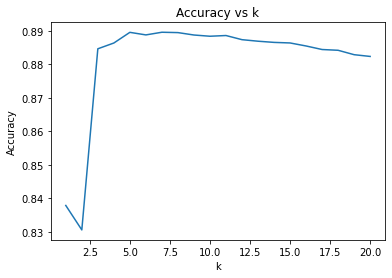

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Finding K that gives the best accuracy
k_values = np.arange(1, 21)

accuracies = []

for k in k_values:
    
    knnT_model = KNeighborsClassifier(n_neighbors=k)
    
    knnT_model.fit(X_train_T, y_train_T)

    y_pred_T = knnT_model.predict(X_test_T)
    
    # Calculating the accuracy of the model
    accuracy = accuracy_score(y_test_T, y_pred_T)
    
    # Appending the accuracy to the list of accuracies
    accuracies.append(accuracy)

# Ploting the accuracies 
plt.plot(k_values, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()

We can see that K = 7 gives the best accuracy, which is 88.96%.

<a id="13"></a>
<h3 style="background-color:#89ABE3FF;font-family:serif;color:white;font-size:300%;text-align:center;border-radius: 15px 50px;"> Predicting EMPLOI_STATUTAIRE in the dataframe</h3>

In [50]:
# Getting the data with empty EMPLOI_STATUTAIRE and existing LIBELLE_EMPLOI_GRADE
data_test_T = data.loc[(data['EMPLOI_STATUTAIRE'] == '') & (data['LIBELLE_EMPLOI_GRADE'] != '') & (data['STATUT_AGENT'] == 'T')]
data_test_H = data.loc[(data['EMPLOI_STATUTAIRE'] == '') & (data['LIBELLE_EMPLOI_GRADE'] != '') & (data['STATUT_AGENT'] == 'H')]

In [57]:
# Tokenizing thz labels
data_test_T['processed_LIBELLE_EMPLOI_GRADE'] = data_test_T['LIBELLE_EMPLOI_GRADE'].apply(preprocess_sentence)
data_test_H['processed_LIBELLE_EMPLOI_GRADE'] = data_test_H['LIBELLE_EMPLOI_GRADE'].apply(preprocess_sentence)

In [59]:
# Word embedding 
data_test_T['LIBELLE_EMPLOI_GRADE_vector'] = data_test_T['processed_LIBELLE_EMPLOI_GRADE'].apply(get_sentence_vector)
data_test_H['LIBELLE_EMPLOI_GRADE_vector'] = data_test_H['processed_LIBELLE_EMPLOI_GRADE'].apply(get_sentence_vector)

In [61]:
# vectors for prediction
vectors_T = data_test_T['LIBELLE_EMPLOI_GRADE_vector'].tolist()
vectors_H = data_test_H['LIBELLE_EMPLOI_GRADE_vector'].tolist()

In [77]:
from tqdm import tqdm

# Getting a list of the predicted values
predicted_T = []

# Create a progress bar with tqdm
for vec in tqdm(vectors_T, desc='Predicting EMPLOI_STATUTAIRE'):
    # Predict the EMPLOI_STATUTAIRE based on the vector representation
    predicted_code = knnT_model.predict([vec])[0]
    predicted_T.append(predicted_code)

Predicting EMPLOI_STATUTAIRE: 100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s]


In [73]:
# Adding the predicted values to the DataFrame
data_test_T['EMPLOI_STATUTAIRE'] = predicted_T

In [ ]:
predicted_H = []

for vec in tqdm(vectors_T, desc='Predicting EMPLOI_STATUTAIRE'):
    # Predict the EMPLOI_STATUTAIRE based on the vector representation
    predicted_code = knnT_model.predict([vec])[0]
    predicted_T.append(predicted_code)

In [ ]:
# Adding the predicted values to the DataFrame
data_test_H['EMPLOI_STATUTAIRE'] = predicted_H